In [1]:
import sys
import os
project_path = '../../..'
sys.path.append(os.path.abspath(project_path))

In [2]:
from matplotlib import pyplot as plt
import numpy as np

# Load Synthetic Data

In [3]:
num_states = 2
D = 1
emission_dist = 't'
save_path = '2020_2states'
folder_path = f"{project_path}/data/synthetic/{emission_dist}-hmm/{save_path}"
s_filename = f"{folder_path}/S_data.npy"
x_filename = f"{folder_path}/X_data.npy"
S = np.load(s_filename)
X = np.load(x_filename)

In [4]:
from data_code.dataloader import create_dataloaders, create_datasets

window_size = 390
batch_size = 32

train_loader, val_loader, test_loader = create_dataloaders(
    X, S, window_size=window_size, train_ratio=0.6, val_ratio=0.2, batch_size=batch_size, standardize=True, feature_engineer=True
)

In [5]:
class ModelParams:
    name = 'mixture_vae'
    
    # backbone parameters
    tau = 0.1
    hard = False
    transition = 'jump'
    lamda_m = 1.0
    lamda_i = 1.0
    lamda_t = 1.0
    seq_len = window_size
    feature = D * 15
    n_cluster = num_states
    hidden_dim = 16
    loss_clamp = batch_size * window_size * 10
    loss_mode = 'sum'
    
    # s_x
    s_x_type = 'lstm'
    s_clamp = 5
    s_x_dropout = 0.1
    s_x_lstm_hidden = 64
    s_x_lstm_layers = 1
    
    # z_s (p)
    
    # z_sx (q)
    z_sx_type = 'mlp'
    z_sx_dropout = 0.1
    z_sx_hiddens = [128, 128]
    
    ######################################
    reconstruction_on_s = True # if True use x_sz else x_z
    
    # x_sz
    x_sz_type = 'mlp'
    reconstruction_on_z = 'p'
    x_sz_dropout = 0.1
    x_sz_hiddens = [128, 128]
    
    # x_z
    x_z_type = 'mlp'
    reconstruction_on_z = 'p'
    x_z_dropout = 0.1
    x_z_hiddens = [128, 128]

model_params = ModelParams

In [6]:
import optuna
import numpy as np
import json
from model.vae_module import VAEModule
from utils.metrics import balanced_accuracy
import os

# Construct the grid for lamda
grid_values = [1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 9.0, 12.0, 15.0, 20.0, 30.0, 40.0, 60.0, 80.0, 100.0]

def objective(trial):
    # Select a lamda value from the predefined grid
    lamda = trial.suggest_categorical("lamda", grid_values)
    
    # Assign the lamda value to the model parameters
    model_params.lamda_m = lamda
    model_params.lamda_i = lamda
    model_params.lamda_t = lamda
    
    vae_module = VAEModule(model_params)
    vae_module.fit(train_loader, lr=1e-3, epochs=300)
    
    # Evaluate model performance on the validation set
    true_s_val, pred_s_val = vae_module.inference(val_loader)
    val_bal_acc = balanced_accuracy(true_s_val.ravel(), pred_s_val.ravel(), n_classes=num_states)
    
    return val_bal_acc

# Define the search space
search_space = {"lamda": grid_values}
sampler = optuna.samplers.GridSampler(search_space)

# Create an Optuna Study with the objective of maximizing Balanced Accuracy
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective)

# Output the best hyperparameters
print("Best trial:")
best_trial = study.best_trial
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

# Save the best hyperparameters to a file
best_params = best_trial.params

os.makedirs(f"{project_path}/hyper_parameter/best_vae", exist_ok=True)
param_file_name = f"{project_path}/hyper_parameter/best_vae/{save_path}.json"
with open(param_file_name, "w") as f:
    json.dump(best_params, f, indent=4)

print("Best hyperparameters saved to 'best_hyperparameters.json'.")


[I 2025-03-24 13:59:13,931] A new study created in memory with name: no-name-828376ae-b3ca-4ca9-8de7-038f0cfc6221


Epoch [20/300], VAE Loss: 7035.2757
Epoch [40/300], VAE Loss: 6836.1314
Epoch [60/300], VAE Loss: 6814.8416
Epoch [80/300], VAE Loss: 6800.5708
Epoch [100/300], VAE Loss: 6790.2577
Epoch [120/300], VAE Loss: 6785.2615
Epoch [140/300], VAE Loss: 6780.8837
Epoch [160/300], VAE Loss: 6772.7883
Epoch [180/300], VAE Loss: 6769.6760
Epoch [200/300], VAE Loss: 6767.4245
Epoch [220/300], VAE Loss: 6762.3227
Epoch [240/300], VAE Loss: 6762.1765
Epoch [260/300], VAE Loss: 6758.7660
Epoch [280/300], VAE Loss: 6764.5398


[I 2025-03-24 14:00:01,059] Trial 0 finished with value: 0.5789054727461072 and parameters: {'lamda': 2.0}. Best is trial 0 with value: 0.5789054727461072.


Epoch [300/300], VAE Loss: 6755.8055
Epoch [20/300], VAE Loss: 13745.3744
Epoch [40/300], VAE Loss: 13511.4904
Epoch [60/300], VAE Loss: 13441.8170
Epoch [80/300], VAE Loss: 13391.2559
Epoch [100/300], VAE Loss: 13371.3507
Epoch [120/300], VAE Loss: 13360.3619
Epoch [140/300], VAE Loss: 13343.6742
Epoch [160/300], VAE Loss: 13327.7112
Epoch [180/300], VAE Loss: 13331.0635
Epoch [200/300], VAE Loss: 13319.6471
Epoch [220/300], VAE Loss: 13314.3879
Epoch [240/300], VAE Loss: 13305.5455
Epoch [260/300], VAE Loss: 13292.8460
Epoch [280/300], VAE Loss: 13292.5664


[I 2025-03-24 14:00:47,101] Trial 1 finished with value: 0.6224551227789608 and parameters: {'lamda': 9.0}. Best is trial 1 with value: 0.6224551227789608.


Epoch [300/300], VAE Loss: 13290.9641
Epoch [20/300], VAE Loss: 19513.4355
Epoch [40/300], VAE Loss: 19128.7406
Epoch [60/300], VAE Loss: 19005.1078
Epoch [80/300], VAE Loss: 18937.1362
Epoch [100/300], VAE Loss: 18891.8507
Epoch [120/300], VAE Loss: 18853.3858
Epoch [140/300], VAE Loss: 18834.4808
Epoch [160/300], VAE Loss: 18802.5654
Epoch [180/300], VAE Loss: 18803.0084
Epoch [200/300], VAE Loss: 18779.8668
Epoch [220/300], VAE Loss: 18776.4600
Epoch [240/300], VAE Loss: 18768.0398
Epoch [260/300], VAE Loss: 18772.6883
Epoch [280/300], VAE Loss: 18754.7821


[I 2025-03-24 14:01:33,291] Trial 2 finished with value: 0.6361353099715985 and parameters: {'lamda': 15.0}. Best is trial 2 with value: 0.6361353099715985.


Epoch [300/300], VAE Loss: 18773.3505
Epoch [20/300], VAE Loss: 23909.9841
Epoch [40/300], VAE Loss: 23613.6258
Epoch [60/300], VAE Loss: 23479.8946
Epoch [80/300], VAE Loss: 23413.4473
Epoch [100/300], VAE Loss: 23373.5159
Epoch [120/300], VAE Loss: 23331.4060
Epoch [140/300], VAE Loss: 23317.1140
Epoch [160/300], VAE Loss: 23290.8615
Epoch [180/300], VAE Loss: 23282.6352
Epoch [200/300], VAE Loss: 23261.5184
Epoch [220/300], VAE Loss: 23249.3260
Epoch [240/300], VAE Loss: 23259.2896
Epoch [260/300], VAE Loss: 23242.9886
Epoch [280/300], VAE Loss: 23235.7982


[I 2025-03-24 14:02:19,576] Trial 3 finished with value: 0.6375901095837984 and parameters: {'lamda': 20.0}. Best is trial 3 with value: 0.6375901095837984.


Epoch [300/300], VAE Loss: 23235.0478
Epoch [20/300], VAE Loss: 100418.4542
Epoch [40/300], VAE Loss: 96952.4624
Epoch [60/300], VAE Loss: 96166.0261
Epoch [80/300], VAE Loss: 95718.3333
Epoch [100/300], VAE Loss: 95419.4461
Epoch [120/300], VAE Loss: 95207.5114
Epoch [140/300], VAE Loss: 95019.8105
Epoch [160/300], VAE Loss: 94888.8039
Epoch [180/300], VAE Loss: 94765.6863
Epoch [200/300], VAE Loss: 94689.7255
Epoch [220/300], VAE Loss: 94623.2500
Epoch [240/300], VAE Loss: 94567.1781
Epoch [260/300], VAE Loss: 94521.6683
Epoch [280/300], VAE Loss: 94482.0801


[I 2025-03-24 14:03:05,847] Trial 4 finished with value: 0.6219848345942696 and parameters: {'lamda': 100.0}. Best is trial 3 with value: 0.6375901095837984.


Epoch [300/300], VAE Loss: 94439.0408
Epoch [20/300], VAE Loss: 10050.4424
Epoch [40/300], VAE Loss: 9841.9569
Epoch [60/300], VAE Loss: 9742.3497
Epoch [80/300], VAE Loss: 9700.0822
Epoch [100/300], VAE Loss: 9666.6069
Epoch [120/300], VAE Loss: 9652.9932
Epoch [140/300], VAE Loss: 9634.5401
Epoch [160/300], VAE Loss: 9630.6119
Epoch [180/300], VAE Loss: 9622.8842
Epoch [200/300], VAE Loss: 9610.4424
Epoch [220/300], VAE Loss: 9605.9073
Epoch [240/300], VAE Loss: 9594.9044
Epoch [260/300], VAE Loss: 9605.6256
Epoch [280/300], VAE Loss: 9598.2347


[I 2025-03-24 14:03:52,424] Trial 5 finished with value: 0.6011449415126743 and parameters: {'lamda': 5.0}. Best is trial 3 with value: 0.6375901095837984.


Epoch [300/300], VAE Loss: 9598.2095
Epoch [20/300], VAE Loss: 7893.1701
Epoch [40/300], VAE Loss: 7799.1161
Epoch [60/300], VAE Loss: 7771.4223
Epoch [80/300], VAE Loss: 7751.3446
Epoch [100/300], VAE Loss: 7739.9072
Epoch [120/300], VAE Loss: 7735.4190
Epoch [140/300], VAE Loss: 7736.8477
Epoch [160/300], VAE Loss: 7727.3930
Epoch [180/300], VAE Loss: 7722.3299
Epoch [200/300], VAE Loss: 7717.9065
Epoch [220/300], VAE Loss: 7717.7638
Epoch [240/300], VAE Loss: 7717.8279
Epoch [260/300], VAE Loss: 7716.6552
Epoch [280/300], VAE Loss: 7713.3302


[I 2025-03-24 14:04:38,689] Trial 6 finished with value: 0.5862896745779062 and parameters: {'lamda': 3.0}. Best is trial 3 with value: 0.6375901095837984.


Epoch [300/300], VAE Loss: 7704.6834
Epoch [20/300], VAE Loss: 84100.2851
Epoch [40/300], VAE Loss: 78657.7386
Epoch [60/300], VAE Loss: 78030.0703
Epoch [80/300], VAE Loss: 77667.2549
Epoch [100/300], VAE Loss: 77420.2451
Epoch [120/300], VAE Loss: 77249.3480
Epoch [140/300], VAE Loss: 77108.3905
Epoch [160/300], VAE Loss: 77016.1413
Epoch [180/300], VAE Loss: 76949.9338
Epoch [200/300], VAE Loss: 76876.8660
Epoch [220/300], VAE Loss: 76829.8423
Epoch [240/300], VAE Loss: 76796.4281
Epoch [260/300], VAE Loss: 76751.6667
Epoch [280/300], VAE Loss: 76731.6062


[I 2025-03-24 14:05:24,935] Trial 7 finished with value: 0.6285832090947523 and parameters: {'lamda': 80.0}. Best is trial 3 with value: 0.6375901095837984.


Epoch [300/300], VAE Loss: 76703.2198
Epoch [20/300], VAE Loss: 33702.9138
Epoch [40/300], VAE Loss: 32995.6462
Epoch [60/300], VAE Loss: 32741.7283
Epoch [80/300], VAE Loss: 32595.3186
Epoch [100/300], VAE Loss: 32496.0114
Epoch [120/300], VAE Loss: 32428.4073
Epoch [140/300], VAE Loss: 32368.3346
Epoch [160/300], VAE Loss: 32334.1981
Epoch [180/300], VAE Loss: 32306.4236
Epoch [200/300], VAE Loss: 32295.3337
Epoch [220/300], VAE Loss: 32271.8554
Epoch [240/300], VAE Loss: 32261.1732
Epoch [260/300], VAE Loss: 32243.8002
Epoch [280/300], VAE Loss: 32246.8476


[I 2025-03-24 14:06:11,098] Trial 8 finished with value: 0.6397311503955619 and parameters: {'lamda': 30.0}. Best is trial 8 with value: 0.6397311503955619.


Epoch [300/300], VAE Loss: 32235.1356
Epoch [20/300], VAE Loss: 17759.2514
Epoch [40/300], VAE Loss: 16608.0950
Epoch [60/300], VAE Loss: 16329.3337
Epoch [80/300], VAE Loss: 16247.5805
Epoch [100/300], VAE Loss: 16194.7653
Epoch [120/300], VAE Loss: 16161.3072
Epoch [140/300], VAE Loss: 16140.9614
Epoch [160/300], VAE Loss: 16109.7692
Epoch [180/300], VAE Loss: 16100.1107
Epoch [200/300], VAE Loss: 16085.5476
Epoch [220/300], VAE Loss: 16075.9267
Epoch [240/300], VAE Loss: 16068.6567
Epoch [260/300], VAE Loss: 16054.6640
Epoch [280/300], VAE Loss: 16064.8207


[I 2025-03-24 14:06:57,257] Trial 9 finished with value: 0.6334001085195936 and parameters: {'lamda': 12.0}. Best is trial 8 with value: 0.6397311503955619.


Epoch [300/300], VAE Loss: 16043.3958
Epoch [20/300], VAE Loss: 42749.4869
Epoch [40/300], VAE Loss: 42020.4534
Epoch [60/300], VAE Loss: 41736.8856
Epoch [80/300], VAE Loss: 41572.6703
Epoch [100/300], VAE Loss: 41464.4232
Epoch [120/300], VAE Loss: 41378.2320
Epoch [140/300], VAE Loss: 41311.7855
Epoch [160/300], VAE Loss: 41271.1348
Epoch [180/300], VAE Loss: 41228.1413
Epoch [200/300], VAE Loss: 41201.5204
Epoch [220/300], VAE Loss: 41187.8603
Epoch [240/300], VAE Loss: 41165.0400
Epoch [260/300], VAE Loss: 41159.1095
Epoch [280/300], VAE Loss: 41142.7884


[I 2025-03-24 14:07:43,446] Trial 10 finished with value: 0.6373464835843978 and parameters: {'lamda': 40.0}. Best is trial 8 with value: 0.6397311503955619.


Epoch [300/300], VAE Loss: 41138.6691
Epoch [20/300], VAE Loss: 8960.5978
Epoch [40/300], VAE Loss: 8806.7055
Epoch [60/300], VAE Loss: 8760.4809
Epoch [80/300], VAE Loss: 8736.7181
Epoch [100/300], VAE Loss: 8712.3433
Epoch [120/300], VAE Loss: 8704.1446
Epoch [140/300], VAE Loss: 8694.1691
Epoch [160/300], VAE Loss: 8685.2010
Epoch [180/300], VAE Loss: 8679.0173
Epoch [200/300], VAE Loss: 8674.2107
Epoch [220/300], VAE Loss: 8672.4854
Epoch [240/300], VAE Loss: 8674.1745
Epoch [260/300], VAE Loss: 8668.6243
Epoch [280/300], VAE Loss: 8655.7239


[I 2025-03-24 14:08:29,523] Trial 11 finished with value: 0.5930994560351637 and parameters: {'lamda': 4.0}. Best is trial 8 with value: 0.6397311503955619.


Epoch [300/300], VAE Loss: 8655.7708
Epoch [20/300], VAE Loss: 6081.9974
Epoch [40/300], VAE Loss: 5845.0006
Epoch [60/300], VAE Loss: 5823.3759
Epoch [80/300], VAE Loss: 5814.6504
Epoch [100/300], VAE Loss: 5809.8011
Epoch [120/300], VAE Loss: 5804.8903
Epoch [140/300], VAE Loss: 5799.1913
Epoch [160/300], VAE Loss: 5800.7158
Epoch [180/300], VAE Loss: 5794.8628
Epoch [200/300], VAE Loss: 5794.3535
Epoch [220/300], VAE Loss: 5796.1688
Epoch [240/300], VAE Loss: 5790.0827
Epoch [260/300], VAE Loss: 5786.5005
Epoch [280/300], VAE Loss: 5794.7137


[I 2025-03-24 14:09:16,018] Trial 12 finished with value: 0.578992183464992 and parameters: {'lamda': 1.0}. Best is trial 8 with value: 0.6397311503955619.


Epoch [300/300], VAE Loss: 5791.5044
Epoch [20/300], VAE Loss: 11888.3438
Epoch [40/300], VAE Loss: 11685.7900
Epoch [60/300], VAE Loss: 11622.7312
Epoch [80/300], VAE Loss: 11575.3615
Epoch [100/300], VAE Loss: 11549.5086
Epoch [120/300], VAE Loss: 11533.1042
Epoch [140/300], VAE Loss: 11516.7794
Epoch [160/300], VAE Loss: 11501.0752
Epoch [180/300], VAE Loss: 11493.0453
Epoch [200/300], VAE Loss: 11486.2028
Epoch [220/300], VAE Loss: 11472.6215
Epoch [240/300], VAE Loss: 11470.7588
Epoch [260/300], VAE Loss: 11463.2753
Epoch [280/300], VAE Loss: 11461.7114


[I 2025-03-24 14:10:02,454] Trial 13 finished with value: 0.6101044592619496 and parameters: {'lamda': 7.0}. Best is trial 8 with value: 0.6397311503955619.


Epoch [300/300], VAE Loss: 11460.1148
Epoch [20/300], VAE Loss: 61458.6258
Epoch [40/300], VAE Loss: 60226.1381
Epoch [60/300], VAE Loss: 59773.1650
Epoch [80/300], VAE Loss: 59529.0760
Epoch [100/300], VAE Loss: 59344.4297
Epoch [120/300], VAE Loss: 59218.2345
Epoch [140/300], VAE Loss: 59126.5417
Epoch [160/300], VAE Loss: 59065.5703
Epoch [180/300], VAE Loss: 59029.0997
Epoch [200/300], VAE Loss: 58997.7900
Epoch [220/300], VAE Loss: 58972.0131
Epoch [240/300], VAE Loss: 58944.2745
Epoch [260/300], VAE Loss: 58923.7541
Epoch [280/300], VAE Loss: 58911.8652


[I 2025-03-24 14:10:48,765] Trial 14 finished with value: 0.6328835969924989 and parameters: {'lamda': 60.0}. Best is trial 8 with value: 0.6397311503955619.


Epoch [300/300], VAE Loss: 58890.6078
Best trial:
  lamda: 30.0
Best hyperparameters saved to 'best_hyperparameters.json'.


In [19]:
# Load the best hyper-parameter
with open(param_file_name, "r") as f:
    loaded_params = json.load(f)

print("Loaded hyperparameters:")
print(loaded_params)

model_params.lamda_m = loaded_params['lamda']
model_params.lamda_i = loaded_params['lamda']
model_params.lamda_t = loaded_params['lamda']

vae_module = VAEModule(model_params)
vae_module.fit(train_loader, lr=1e-3, epochs=300)

Loaded hyperparameters:
{'lamda': 30.0}
Epoch [20/300], VAE Loss: 34221.8419
Epoch [40/300], VAE Loss: 32921.6977
Epoch [60/300], VAE Loss: 32683.8697
Epoch [80/300], VAE Loss: 32546.8848
Epoch [100/300], VAE Loss: 32457.7712
Epoch [120/300], VAE Loss: 32397.4869
Epoch [140/300], VAE Loss: 32335.1900
Epoch [160/300], VAE Loss: 32308.7410
Epoch [180/300], VAE Loss: 32281.7418
Epoch [200/300], VAE Loss: 32268.7398
Epoch [220/300], VAE Loss: 32254.3235
Epoch [240/300], VAE Loss: 32240.7345
Epoch [260/300], VAE Loss: 32228.4203
Epoch [280/300], VAE Loss: 32220.1152
Epoch [300/300], VAE Loss: 32212.3689


In [20]:
true_s_train_vae, pred_s_train_vae = vae_module.inference(train_loader)
true_s_test_vae, pred_s_test_vae = vae_module.inference(test_loader)

vae_bal_acc_train = balanced_accuracy(true_s_train_vae.ravel(), pred_s_train_vae.ravel(), n_classes = num_states)
vae_bal_acc_test = balanced_accuracy(true_s_test_vae.ravel(), pred_s_test_vae.ravel(), n_classes = num_states)
print(f"[VAE] Balanced Accuracy [train]: {vae_bal_acc_train:.4f}")
print(f"[VAE] Balanced Accuracy [test]: {vae_bal_acc_test:.4f}")

[VAE] Balanced Accuracy [train]: 0.6482
[VAE] Balanced Accuracy [test]: 0.6495


# Visualization

In [21]:
from utils.visualize import plot_clusters
num = 8
all_x_input, all_z_embed = vae_module.get_embedding(test_loader)
original_embed = all_x_input[:num].reshape(-1, all_x_input.shape[-1])
latent_embed = all_z_embed[:num].reshape(-1, all_z_embed.shape[-1])
pred_label = pred_s_test_vae[:num].ravel()
true_label = true_s_test_vae[:num].ravel()

In [31]:
# align different labels for plotting when necessary
pred_label_plot = pred_label # or 1-pred_label

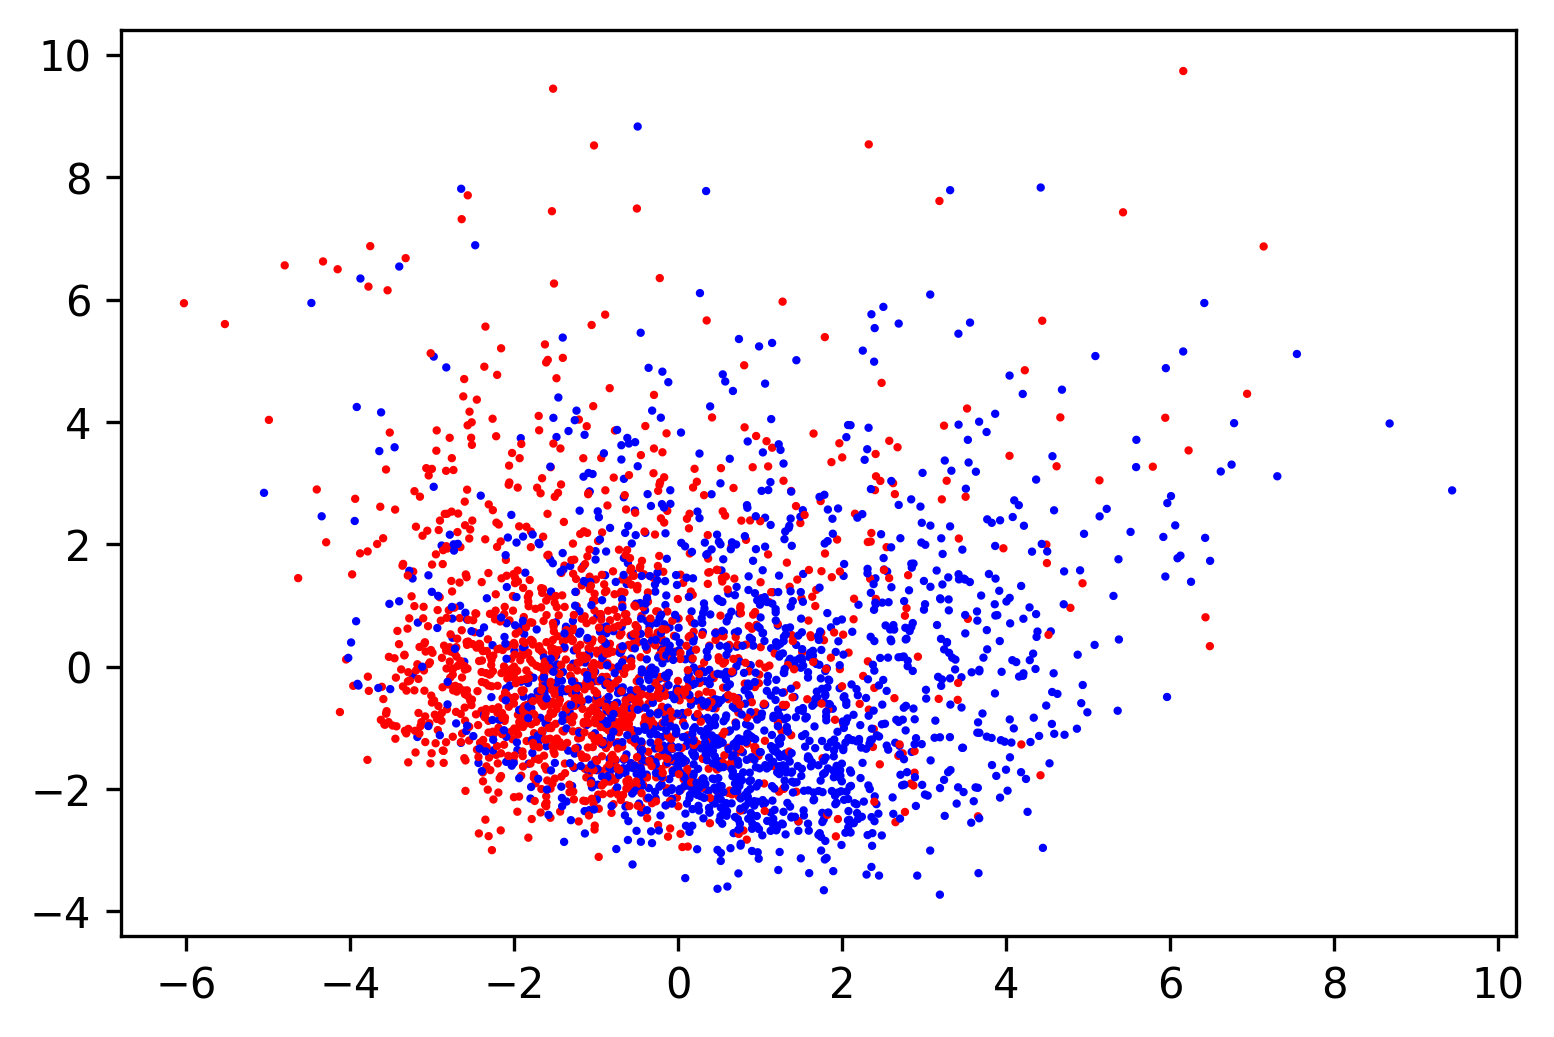

In [32]:
plot_clusters(
    data=original_embed,        
    cluster_labels=true_label,
    cluster_count=num_states,
    colors=['red', 'blue', 'green'],
    label_names=None,
    pca_components=2,
    title=None,
    save_path=f"{project_path}/figures/{save_path}/VAE_origin_true.png",
    dpi=300,
    marker_size=1,
    legend=False
)

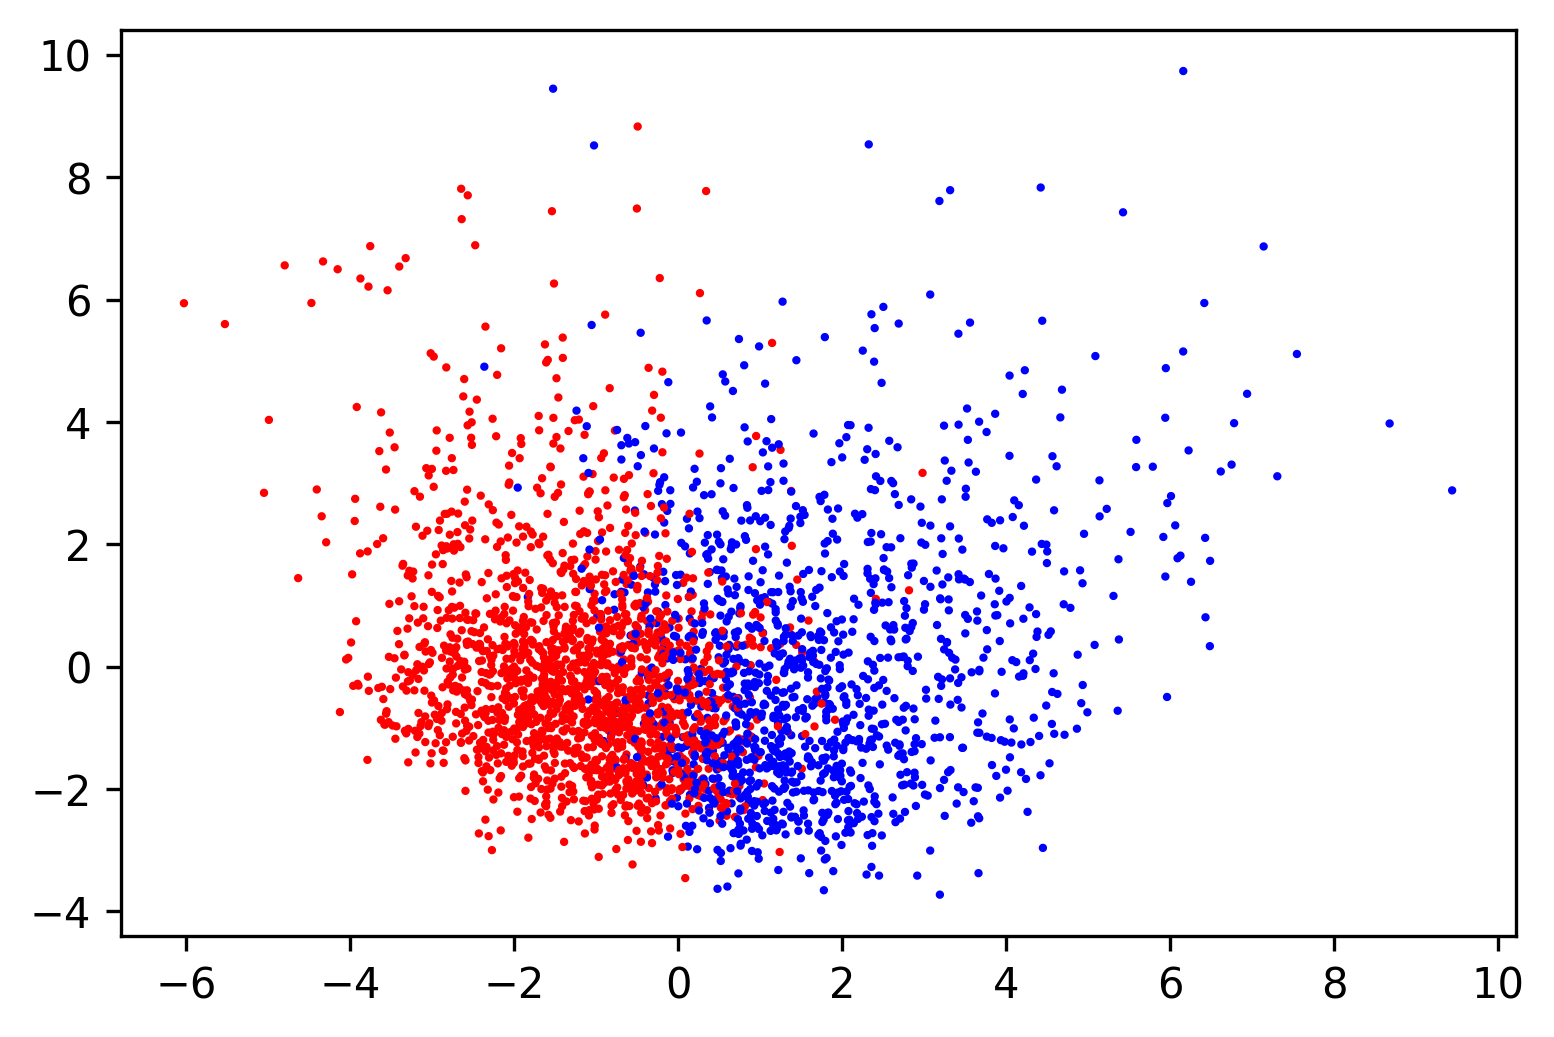

In [33]:
plot_clusters(
    data=original_embed,        
    cluster_labels=pred_label_plot,
    cluster_count=num_states,
    colors=['red', 'blue', 'green'],
    label_names=None,
    pca_components=2,
    title=None,
    save_path=f"{project_path}/figures/{save_path}/VAE_origin_pred.png",
    dpi=300,
    marker_size=1,
    legend=False
)

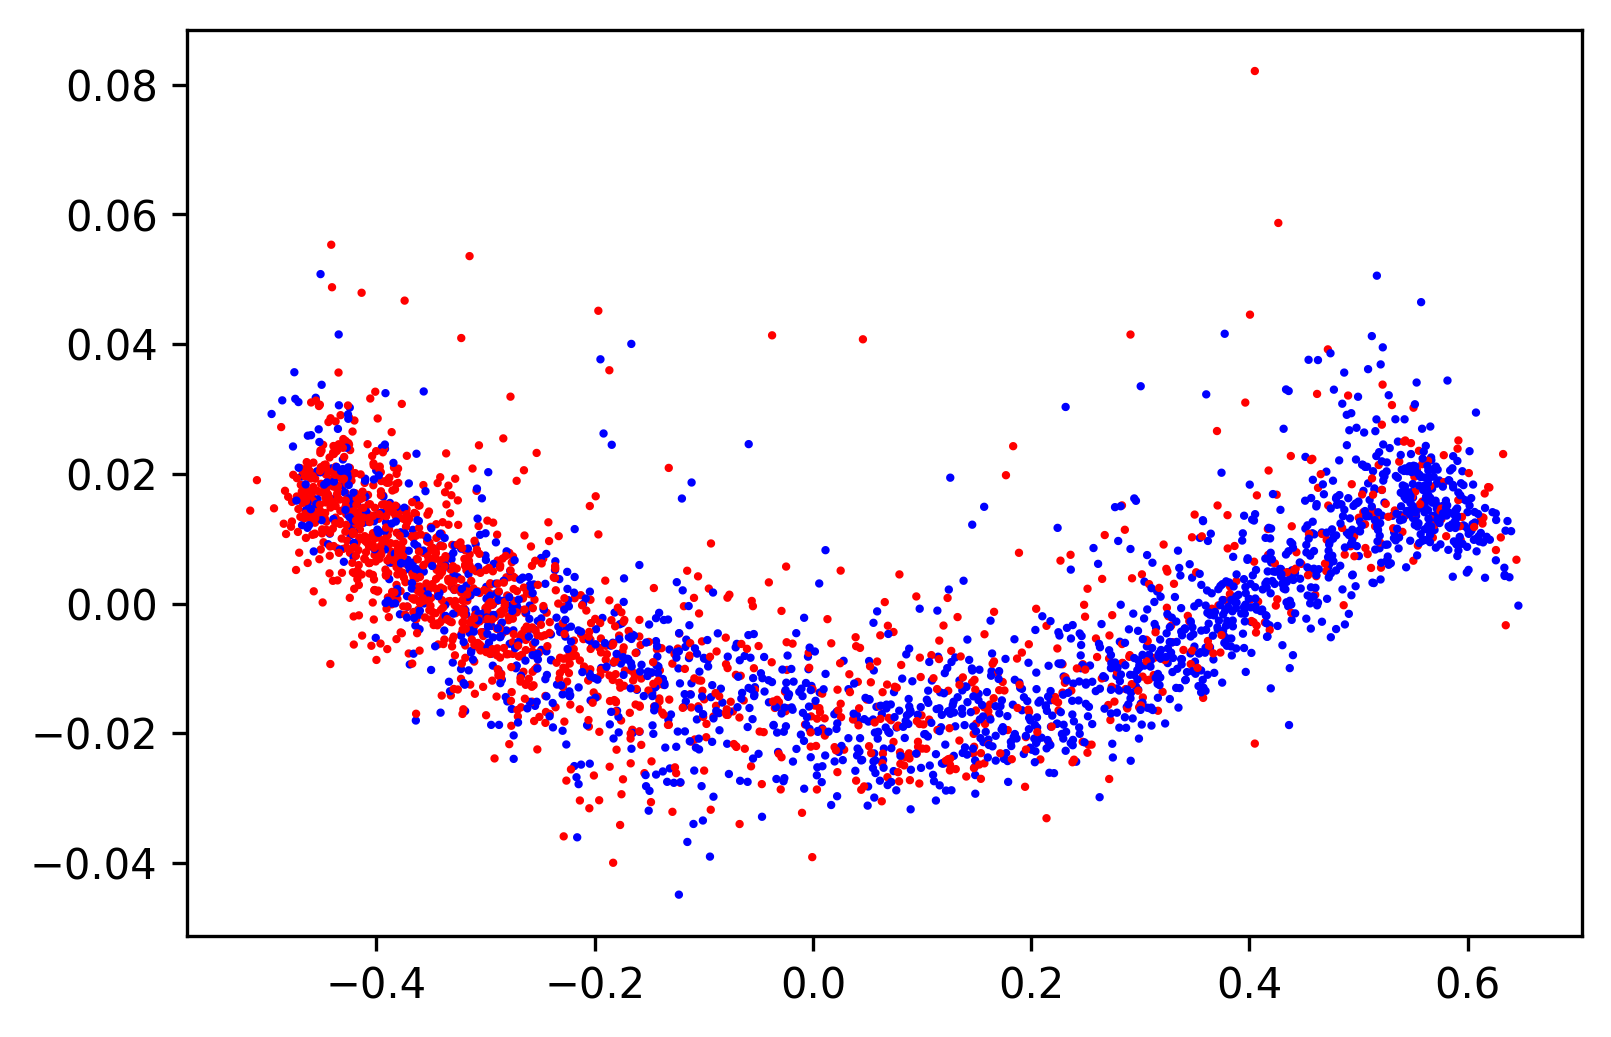

In [34]:
plot_clusters(
    data=latent_embed,        
    cluster_labels=true_label,
    cluster_count=num_states,
    colors=['red', 'blue', 'green'],
    label_names=None,
    pca_components=2,
    title=None,
    save_path=f"{project_path}/figures/{save_path}/VAE_latent_true.png",
    dpi=300,
    marker_size=1,
    legend=False
)

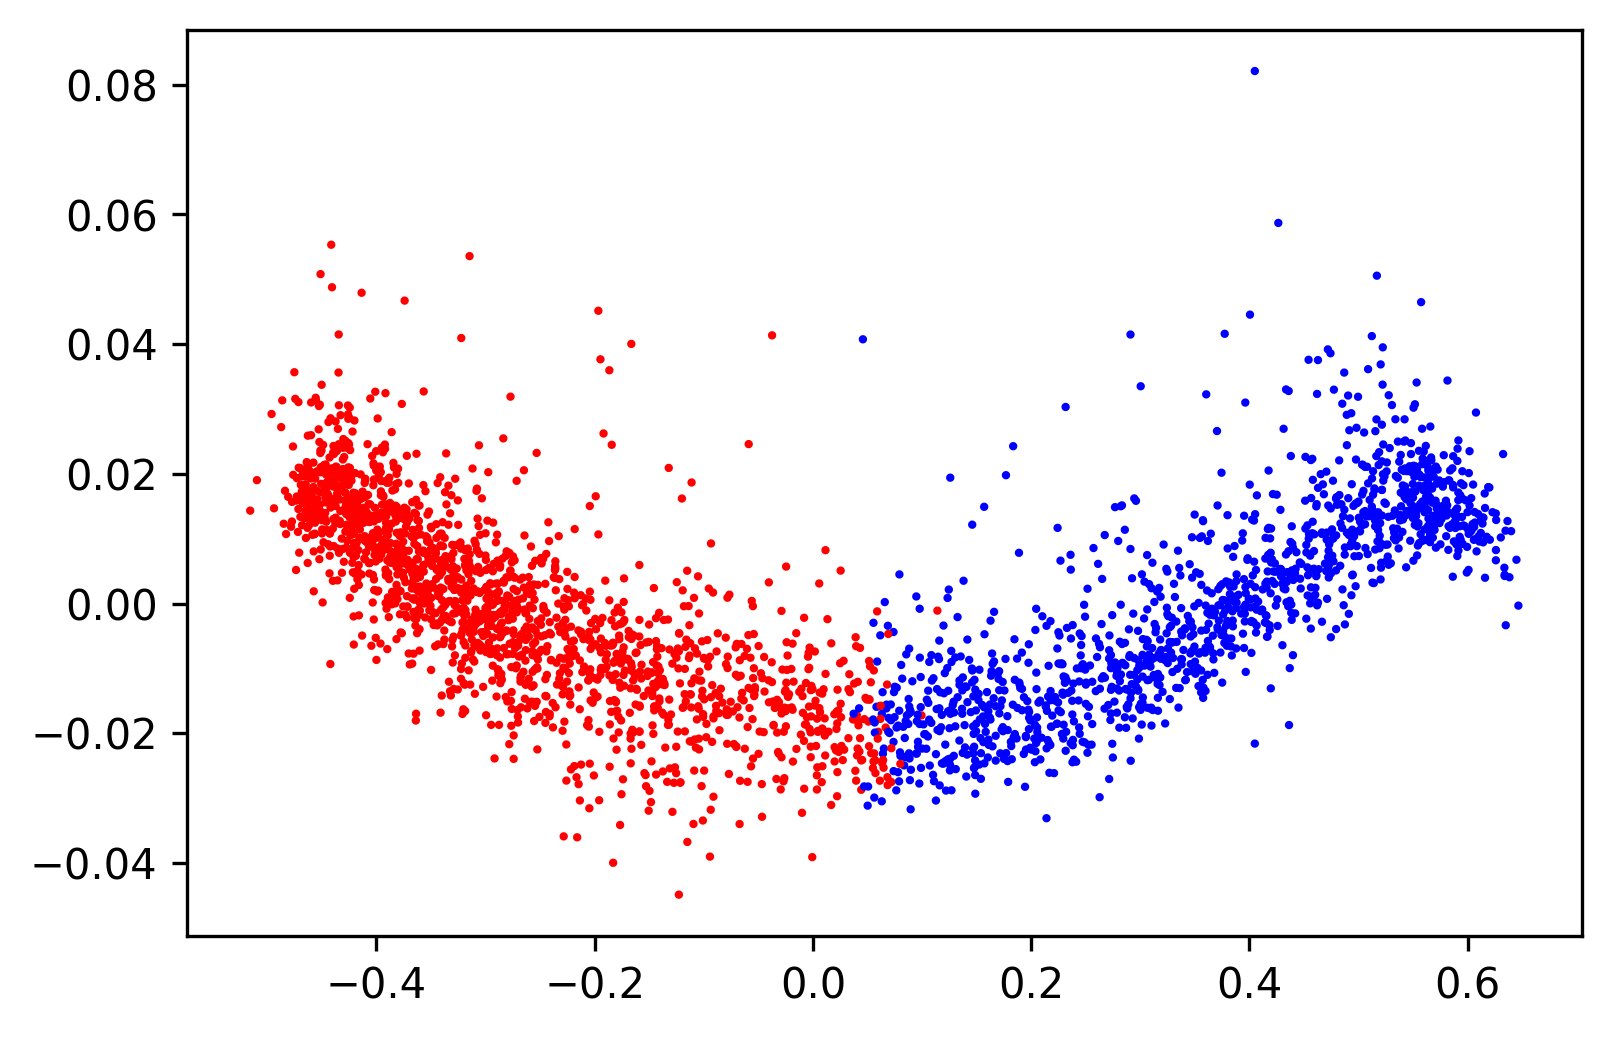

In [35]:
plot_clusters(
    data=latent_embed,        
    cluster_labels=pred_label_plot,
    cluster_count=num_states,
    colors=['red', 'blue', 'green'],
    label_names=None,
    pca_components=2,
    title=None,
    save_path=f"{project_path}/figures/{save_path}/VAE_latent_pred.png",
    dpi=300,
    marker_size=1,
    legend=False
)